In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import warnings
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier, StackingClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline, Pipeline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
from scikeras.wrappers import KerasClassifier

import DataExtract as de
import ContestParticipants as cp
importlib.reload(de)
importlib.reload(cp)

#warnings.simplefilter('ignore')

2023-01-24 02:19:12.921145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<module 'ContestParticipants' from '/Users/yuta/Documents/GitHub/Predict_3ptContest_Participants/ContestParticipants.py'>

## Import Dataset/Preprocessing

In [2]:
# feature values
features = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'GP', 'W_PCT', 
            'MIN', 'FGM', 'FG_PCT', 'FG3M', 'FG3_PCT', 'FTM', 'FT_PCT', 'REB', 'AST', 'TOV', 
            'STL', 'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS', 'DD2', 'TD3']

# Import data set between 2010-11 and 2022-23
df = de.DataExtract(features, 2010)
print('Shape of df: ', df.shape)

# Import the 3point Contest participants table
participants = cp.ContestParticipants()
print('Shape of participants: ', participants.shape)

# Create columns which are the average stats per game in 'df' table
columns = ['MIN', 'FGM', 'FG3M', 'FTM', 'REB', 'AST', 'TOV', 'STL', 
           'BLK', 'PF', 'PTS', 'PLUS_MINUS', 'NBA_FANTASY_PTS']
columns_avg = list(map(lambda s: s + '_avg', columns))
df[columns_avg] = df[columns].div(df['GP'], axis=0)

# Concatenate the target variable (participant)
data = pd.merge(df, participants, on=['Season', 'PLAYER_ID'], how='left')
data['Participant'].where(data['Participant'].notna(), 0, inplace=True)

Shape of df:  (1971, 25)
Shape of participants:  (266, 3)


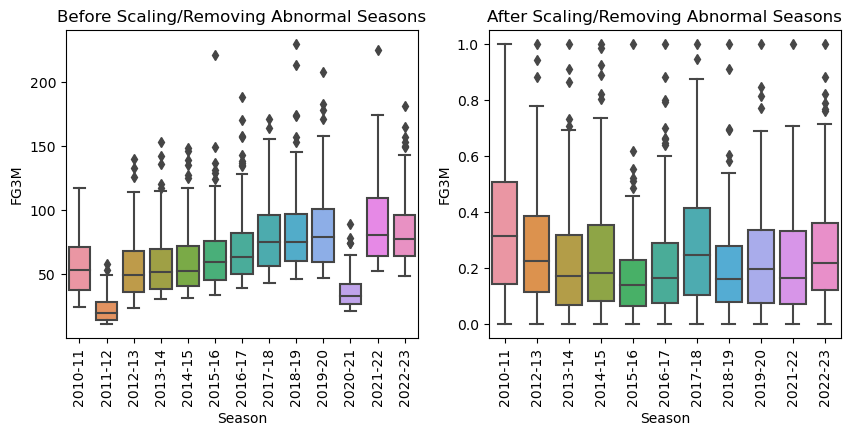

In [3]:
# Boxplot of FG3M by Season
plt.figure(1, figsize=(10, 4))
plt.subplot(1, 2, 1)
ax = sns.boxplot(data = data, x='Season',y=('FG3M'))
plt.title('Before Scaling/Removing Abnormal Seasons')
for item in ax.get_xticklabels():
    item.set_rotation(90)

# Remove two abnormal seasons
# And apply Min-Max scaling by Season
data_scaled = data[(data['Season'] != '2011-12') & (data['Season'] != '2020-21')]

var_for_pinfo = ['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION', 'Season']
var_for_X = ['GP', 'W_PCT', 'FGM', 'FG_PCT', 'FG3M', 'FG3_PCT', 'FTM', 'FT_PCT', 
             'DD2', 'TD3', 'MIN_avg', 'REB_avg', 'AST_avg', 'TOV_avg', 'STL_avg', 
             'BLK_avg', 'PF_avg', 'PTS_avg', 'PLUS_MINUS_avg', 'NBA_FANTASY_PTS_avg']
var_for_y = ['Participant']

for season in data_scaled['Season'].unique():
    scaler = MinMaxScaler()
    scaler.fit(data_scaled.loc[data_scaled['Season']==season, var_for_X])
    data_scaled.loc[data_scaled['Season']==season, var_for_X] = scaler.transform(data_scaled.loc[data_scaled['Season']==season, var_for_X])

data_scaled = data_scaled[var_for_pinfo + var_for_X + var_for_y]

# Boxlpot of FG3M after modificatio
plt.subplot(1, 2, 2)
bx = sns.boxplot(data = data_scaled, x='Season',y=('FG3M'))
plt.title('After Scaling/Removing Abnormal Seasons')
for item in bx.get_xticklabels():
    item.set_rotation(90)
plt.show()

The distribution of every variable varies by season, especially the season of 2011-12 and 2020-21, which are because the seasons were shortend or some games in the season were canceled. Since the difference between these two seasons and others is obviously big, I remove the abnormal seasons from the dataset. In addition, I apply Min-Max scaling to all variables by season.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

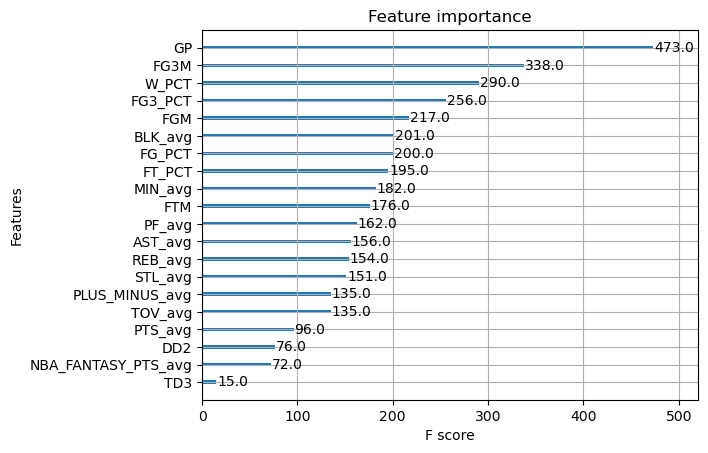

In [4]:
# Divide this dataset into data for ML and data for application
X, y = data_scaled.loc[data_scaled['Season']!='2022-23',var_for_X], data_scaled.loc[data_scaled['Season']!='2022-23','Participant']
X_app = data_scaled.loc[data_scaled['Season']=='2022-23',var_for_X]

# Divide dataset for ML into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Correlation between the target variable and feature variables
#X_y = X_train.copy()
#X_y['Participant'] = y_train
#corr = X_y.corr(method='pearson')
#print(corr['Participant'].sort_values(ascending=False))

# XGBRegressor for feature selection
model_xgb = xgb.XGBRegressor(random_state=42)
pipe = make_pipeline(RandomOverSampler(random_state=42), model_xgb)
pipe.fit(X_train, y_train)
xgb.plot_importance(pipe['xgbregressor'])

I used XGBoost for feature selection. The plot above shows that GP, FG3M, W_PCT, FG3_PCT and FG_PCT seem to be related to the output of "Participant": especially, FG3M and FG3_PCT correspond with our intuition. According to the result, I leave these 4 variables for following modeling step.

                   GP      FG3M     W_PCT   FG3_PCT       FGM  Participant
GP           1.000000  0.298220  0.063830 -0.050622  0.304253     0.079137
FG3M         0.298220  1.000000  0.140155  0.306956  0.490773     0.380873
W_PCT        0.063830  0.140155  1.000000  0.193371  0.078091     0.073852
FG3_PCT     -0.050622  0.306956  0.193371  1.000000 -0.084437     0.210307
FGM          0.304253  0.490773  0.078091 -0.084437  1.000000     0.229704
Participant  0.079137  0.380873  0.073852  0.210307  0.229704     1.000000


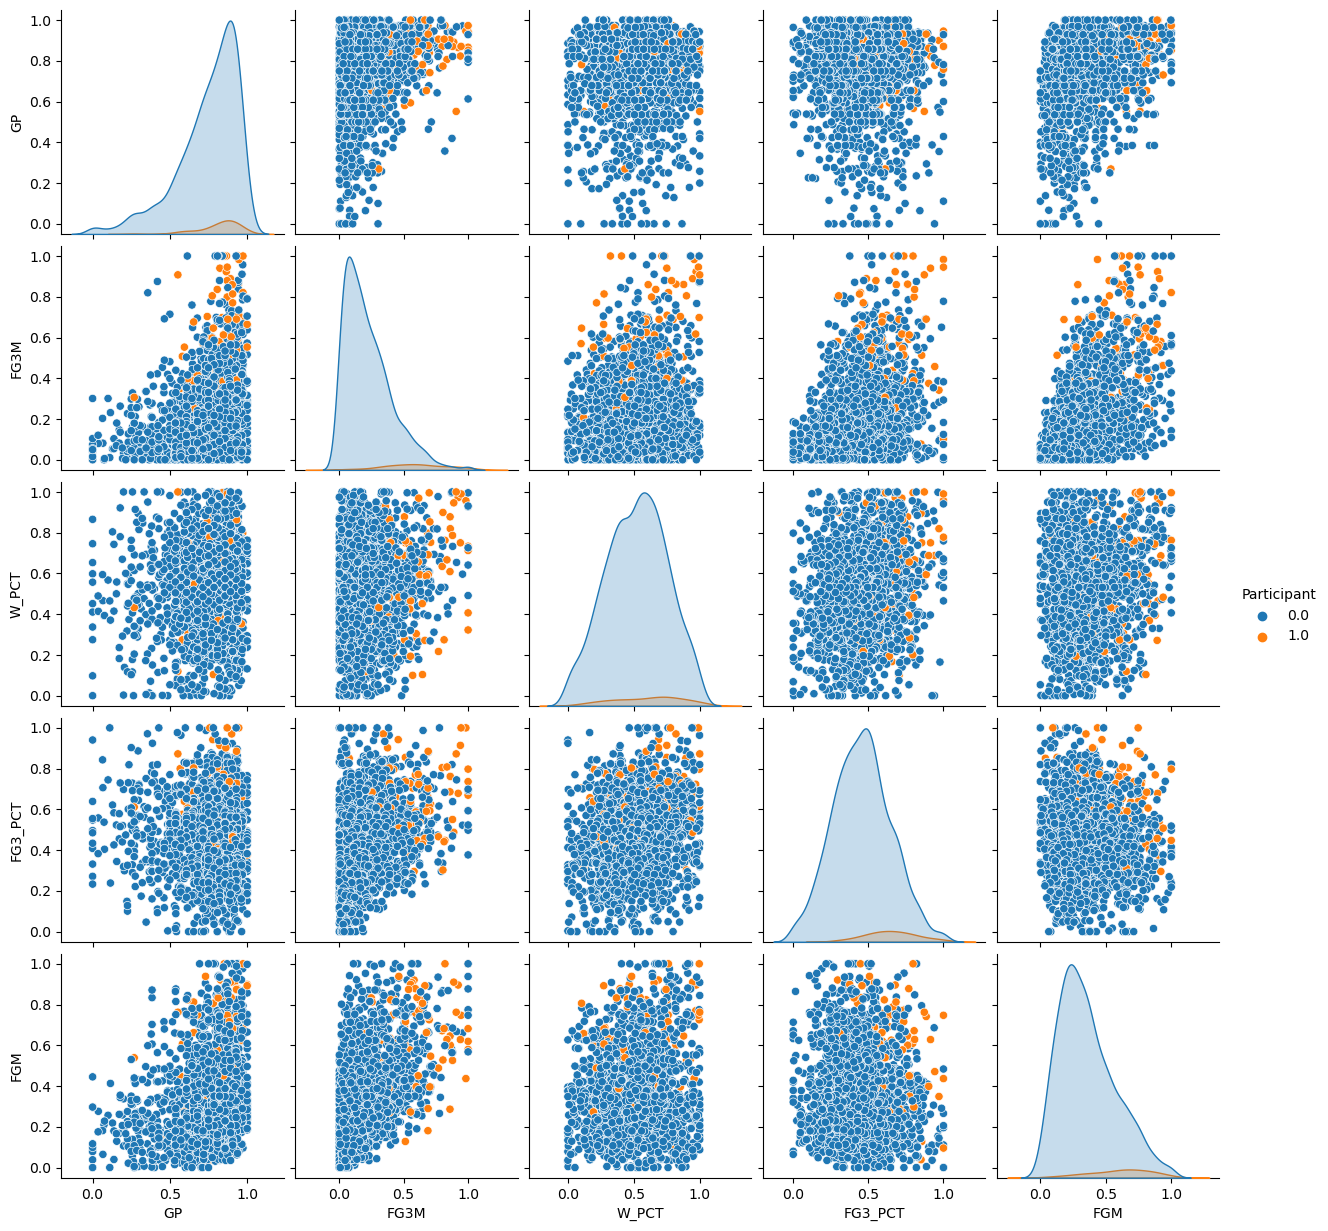

In [5]:
# Simple exploratory Analysis : scatter plots for each pair of feature variables
sns.pairplot(data_scaled[['GP', 'FG3M', 'W_PCT', 'FG3_PCT', 'FGM', 'Participant']], hue='Participant')

# Correlation
corr = data_scaled[['GP', 'FG3M', 'W_PCT', 'FG3_PCT', 'FGM', 'Participant']].corr(method='pearson')
print(corr)


Considering the definitions of variables, FG3_PCT and FG_PCT might have strongly positive correlation. Therefore, I checked the correlation, calculating the value directly and visualizing the pair plots.
As a result, those variables didn't have strong correlation, just corr=0.32.

In [6]:
# Update the X variable columns and dataset
var_for_X = ['GP', 'FG3M', 'FG3_PCT', 'W_PCT', 'FGM']

X, y = data_scaled.loc[data_scaled['Season']!='2022-23',var_for_X], data_scaled.loc[data_scaled['Season']!='2022-23','Participant']
X_app = data_scaled.loc[data_scaled['Season']=='2022-23',var_for_X]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)


## 1. Traditional Machine Learning Model
### Resampling towards imbalanced data

In [19]:
# Apply Over-sampling to deal with imbalanced data
# Use min-max scaler since some varibles are skewed
Resampling = RandomOverSampler(random_state=42)

pipes = []
pipes.append(('scaledLR_Def', (Pipeline([('LR' ,LogisticRegression())]))))
pipes.append(('scaledLR_ROS', (Pipeline([('Resample', Resampling),('LR' ,LogisticRegression(random_state=42))]))))
pipes.append(('scaledKNN_Def', (Pipeline([('KNN' ,KNeighborsClassifier())]))))
pipes.append(('scaledKNN_ROS', (Pipeline([('Resample', Resampling),('KNN' ,KNeighborsClassifier())]))))
pipes.append(('scaledSVC_Def', (Pipeline([('SVC' ,SVC())]))))
pipes.append(('scaledSVC_ROS', (Pipeline([('Resample', Resampling),('SVC' ,SVC(random_state=42))]))))
pipes.append(('scaledGNB_Def', (Pipeline([('GNB' ,GaussianNB())]))))
pipes.append(('scaledGNB_ROS', (Pipeline([('Resample', Resampling),('GNB' ,GaussianNB())]))))

results = []
model_name = []

for pipe ,model in pipes:
    cvs = cross_val_score(model, X_train ,y_train ,cv=5, scoring='f1')
    results.append(cvs)
    model_name.append(pipe)
    msg = "%s: %.3f (%.3f)" % (pipe, cvs.mean(), cvs.std())
    print(msg)


scaledLR_Def: 0.110 (0.135)
scaledLR_ROS: 0.369 (0.032)
scaledKNN_Def: 0.206 (0.082)
scaledKNN_ROS: 0.395 (0.101)
scaledSVC_Def: 0.000 (0.000)
scaledSVC_ROS: 0.388 (0.090)
scaledGNB_Def: 0.461 (0.136)
scaledGNB_ROS: 0.344 (0.046)


We can see that the model's score got higer or the score's STD decreased due to ROS.

### Tuning hyperparameters for each model

In [8]:
# Choose precision score as a metric because the dataset is imbalanced and thus "accuracy" score is biased
# Besides, I would like to avoid False Postive as much as possible
# Explore best hyperparameters for each model using GridSearchCV
# Use 4 models for classification problem
score_metrics = 'precision'
lr = LogisticRegression(random_state=42)
knn = KNeighborsClassifier()
svc = SVC(random_state=42)
gnb = GaussianNB()

# hyperparameters for each model
param_lr = {
  'logisticregression__C': [0.01, 0.1, 1, 10, 100],
  'logisticregression__penalty': ['l1'],
  'logisticregression__solver': ['liblinear']
}

param_knn = {
  'kneighborsclassifier__n_neighbors': range(2,10),
  'kneighborsclassifier__weights': ['uniform', 'distance']
  }

param_svc = {
  'svc__C': [0.001, 0.01, 0.1, 1],
  'svc__kernel': ['poly'],
  'svc__degree': range(2, 5)
  }

param_gnb = {
  'gaussiannb__var_smoothing': np.logspace(0,-9, num=100)
}

models = [(lr, param_lr),(knn, param_knn), (svc, param_svc), (gnb, param_gnb)]

# Search best parameter/model by GridSearchCV
bp = {}
for model, param in models:
  pipe2 = make_pipeline(
    RandomOverSampler(random_state=42),
    model
    )

  grid = GridSearchCV(pipe2, param, cv=5, scoring=score_metrics)
  grid.fit(X_train, y_train)

  bp.update(grid.best_params_)

  print("Best Parameters for %s: %s" % (model, grid.best_params_))
  print("Best Score %s: %.3f" % (model, grid.best_score_))
  

Best Parameters for LogisticRegression(random_state=42): {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
Best Score LogisticRegression(random_state=42): 0.237
Best Parameters for KNeighborsClassifier(): {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'uniform'}
Best Score KNeighborsClassifier(): 0.301
Best Parameters for SVC(random_state=42): {'svc__C': 0.001, 'svc__degree': 4, 'svc__kernel': 'poly'}
Best Score SVC(random_state=42): 0.288
Best Parameters for GaussianNB(): {'gaussiannb__var_smoothing': 1.0}
Best Score GaussianNB(): 0.223


### Test and Predict participants

In [9]:
# test each model using test dataset
model_lr = LogisticRegression(C=bp['logisticregression__C'], penalty='l1', solver='liblinear', random_state=42)
model_knn = KNeighborsClassifier(n_neighbors=bp['kneighborsclassifier__n_neighbors'], weights=bp['kneighborsclassifier__weights'])
model_svc = SVC(C=bp['svc__C'], kernel=bp['svc__kernel'], degree=bp['svc__degree'], random_state=42)
model_gnb = GaussianNB(var_smoothing=bp['gaussiannb__var_smoothing'])

models = [model_lr, model_knn, model_svc, model_gnb]
names = ['LR', 'KNN', 'SVC', 'GNB']

predicts = pd.DataFrame(columns=names)

print('Scores for Test dataset:')
for name, model in zip(names, models):
    pipe3 = make_pipeline(
        RandomOverSampler(random_state=42),
        model
        )
    
    pipe3.fit(X_train, y_train)
    y_pred = pipe3.predict(X_test)
    y_apply = pipe3.predict(X_app)
    predicts[name] = y_apply

    print('%s: F1 %.3f, Precision %.3f, Recall %.3f' % (
        name, f1_score(y_test, y_pred),
        precision_score(y_test, y_pred), recall_score(y_test, y_pred)
        ))



Scores for Test dataset:
LR: F1 0.329, Precision 0.200, Recall 0.933
KNN: F1 0.400, Precision 0.350, Recall 0.467
SVC: F1 0.431, Precision 0.280, Recall 0.933
GNB: F1 0.359, Precision 0.222, Recall 0.933


In [10]:
print('The Number of Predicted Positive: \n', predicts.sum())
print('Predicted Participants:')
data_2022 = data.loc[data['Season']=='2022-23',:].reset_index(drop=True)
data_2022[names] = predicts
data_2022[(data_2022['SVC']==1)].iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42]]

The Number of Predicted Positive: 
 LR     33.0
KNN    11.0
SVC    23.0
GNB    31.0
dtype: float64
Predicted Participants:


,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB
0,Damion Lee,PHX,48,0.500,144,87,0.481,0.0,1.0,0.0,1.0,0.0
1,Kentavious Caldwell-Pope,DEN,46,0.696,187,95,0.468,0.0,1.0,1.0,1.0,1.0
3,Malcolm Brogdon,BOS,41,0.707,203,80,0.455,0.0,1.0,0.0,1.0,0.0
6,Lauri Markkanen,UTA,45,0.511,376,139,0.430,0.0,1.0,1.0,1.0,1.0
8,Jerami Grant,POR,45,0.444,325,111,0.427,0.0,1.0,1.0,1.0,1.0
10,Bojan Bogdanovic,DET,46,0.261,332,116,0.423,0.0,1.0,1.0,1.0,1.0
13,Buddy Hield,IND,48,0.479,299,181,0.422,0.0,1.0,1.0,1.0,1.0
14,Keegan Murray,SAC,44,0.591,193,110,0.421,0.0,1.0,0.0,1.0,1.0
16,Georges Niang,PHI,44,0.659,142,102,0.420,0.0,0.0,1.0,1.0,0.0
17,Stephen Curry,GSW,32,0.500,312,157,0.419,0.0,1.0,0.0,1.0,1.0


## 2. Boosting

In [11]:
# Tuning Hyperparameters of Gradient Boosting Classifier
model_gb = GradientBoostingClassifier()

param_gb = {
    'gradientboostingclassifier__learning_rate':[1,0.9,0.8,0.7,0.6], 
    'gradientboostingclassifier__n_estimators':[600,700,800,900],
    'gradientboostingclassifier__max_depth':range(2,5)
    }

pipe3 = make_pipeline(RandomOverSampler(), model_gb)

grid = GridSearchCV(pipe3, param_gb, cv=5, scoring=score_metrics)
grid.fit(X_train, y_train)

bp2 = {}
bp2.update(grid.best_params_)
print("Best Parameters: %s" % (grid.best_params_))
print("Best Score: %.3f" % (grid.best_score_))

Best Parameters: {'gradientboostingclassifier__learning_rate': 0.6, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 900}
Best Score: 0.500


In [12]:
# Test each model using test dataset
model_gb = GradientBoostingClassifier(
    learning_rate=bp2['gradientboostingclassifier__learning_rate'],
    n_estimators=bp2['gradientboostingclassifier__n_estimators'],
    max_depth=bp2['gradientboostingclassifier__max_depth'],
    random_state=42
    )

print('Scores for Test dataset:')
pipe4 = make_pipeline(
    RandomOverSampler(random_state=42),
    model_gb
    )
pipe4.fit(X_train, y_train)
y_pred = pipe4.predict(X_test)

print('Boosting: F1 %.3f, Precision %.3f, Recall %.3f' % (
    f1_score(y_test, y_pred),
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)
    ))

y_apply = pipe4.predict(X_app)
print('The Number of Predicted Positive: ', y_apply.sum())

# Predict Paricipants
print('Predicted Participants:')
data_2022['Boosting'] = y_apply
data_2022[(data_2022['Boosting']==1)].iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42,43]]

Scores for Test dataset:
Boosting: F1 0.100, Precision 0.200, Recall 0.067
The Number of Predicted Positive:  9.0
Predicted Participants:


,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB,Boosting
1,Kentavious Caldwell-Pope,DEN,46,0.696,187,95,0.468,0.0,1.0,1.0,1.0,1.0,1.0
6,Lauri Markkanen,UTA,45,0.511,376,139,0.430,0.0,1.0,1.0,1.0,1.0,1.0
8,Jerami Grant,POR,45,0.444,325,111,0.427,0.0,1.0,1.0,1.0,1.0,1.0
10,Bojan Bogdanovic,DET,46,0.261,332,116,0.423,0.0,1.0,1.0,1.0,1.0,1.0
13,Buddy Hield,IND,48,0.479,299,181,0.422,0.0,1.0,1.0,1.0,1.0,1.0
88,Anthony Edwards,MIN,49,0.490,425,132,0.367,0.0,1.0,1.0,1.0,1.0,1.0
96,Luka Doncic,DAL,43,0.581,484,123,0.357,0.0,1.0,1.0,1.0,1.0,1.0
102,Jayson Tatum,BOS,45,0.733,456,150,0.352,0.0,1.0,1.0,1.0,1.0,1.0
124,Jalen Green,HOU,46,0.239,343,116,0.332,0.0,0.0,1.0,0.0,1.0,1.0


## 3. Stacking

lr: 0.237 (0.022)
knn: 0.301 (0.090)
svc: 0.288 (0.056)
gnb: 0.223 (0.033)
stacking: 0.368 (0.146)


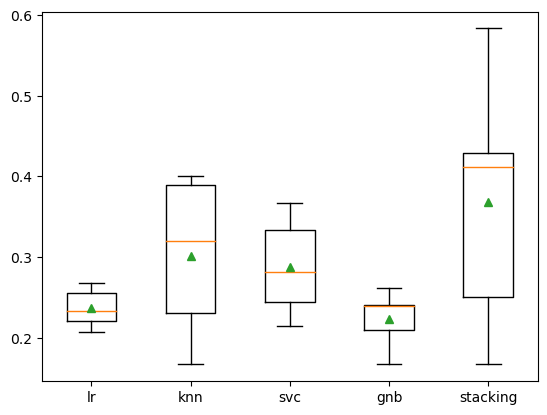

In [13]:
# get a stacking ensemble of models
def get_stacking():
 # define the base models
 level = list()
 level.append(('lr', model_lr))
 level.append(('knn', model_knn))
 level.append(('svc', model_svc))
 level.append(('gnb', model_gnb))
 # define meta learner model
 level1 = LogisticRegression(random_state=42)
 # define the stacking ensemble
 model = StackingClassifier(estimators=level, final_estimator=level1, cv=5)
 return model
 
# get a list of models to evaluate
def get_models():
 models = dict()
 models['lr'] = model_lr
 models['knn'] = model_knn
 models['svc'] = model_svc
 models['gnb'] = model_gnb
 models['stacking'] = get_stacking()
 return models
  
# get the models to evaluate
models = get_models()

results_s, names_s = list(), list()
for name, model in models.items():
    pipe = make_pipeline(
        RandomOverSampler(random_state=42),
        model
        )
    # evaluate the models and store results
    scores = cross_val_score(
        pipe, X_train, y_train, scoring=score_metrics, 
        cv=5, n_jobs=-1, error_score='raise'
        )
    results_s.append(scores)
    names_s.append(name)
    print('%s: %.3f (%.3f)' % (name, scores.mean(), scores.std()))

# plot model performance for comparison
plt.boxplot(results_s, labels=names_s, showmeans=True)
plt.show()

In [14]:
pipe5 = make_pipeline(
    RandomOverSampler(random_state=42),
    models['stacking']
    )

pipe5.fit(X_train, y_train)
y_pred = pipe5.predict(X_test)

print('Stacking: F1 %.3f, Precision %.3f, Recall %.3f' % (
    f1_score(y_test, y_pred), precision_score(y_test, y_pred), 
    recall_score(y_test, y_pred)
    ))

y_apply = pipe5.predict(X_app)
print('The Number of Predicted Positive: ', y_apply.sum())

# Predict Paricipants
print('Predicted Participants:')
data_2022['Stacking'] = y_apply
data_2022[(data_2022['Stacking']==1)].iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42,43,44]]

Stacking: F1 0.452, Precision 0.438, Recall 0.467
The Number of Predicted Positive:  8.0
Predicted Participants:


,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB,Boosting,Stacking
1,Kentavious Caldwell-Pope,DEN,46,0.696,187,95,0.468,0.0,1.0,1.0,1.0,1.0,1.0,1.0
6,Lauri Markkanen,UTA,45,0.511,376,139,0.430,0.0,1.0,1.0,1.0,1.0,1.0,1.0
8,Jerami Grant,POR,45,0.444,325,111,0.427,0.0,1.0,1.0,1.0,1.0,1.0,1.0
10,Bojan Bogdanovic,DET,46,0.261,332,116,0.423,0.0,1.0,1.0,1.0,1.0,1.0,1.0
13,Buddy Hield,IND,48,0.479,299,181,0.422,0.0,1.0,1.0,1.0,1.0,1.0,1.0
88,Anthony Edwards,MIN,49,0.490,425,132,0.367,0.0,1.0,1.0,1.0,1.0,1.0,1.0
96,Luka Doncic,DAL,43,0.581,484,123,0.357,0.0,1.0,1.0,1.0,1.0,1.0,1.0
102,Jayson Tatum,BOS,45,0.733,456,150,0.352,0.0,1.0,1.0,1.0,1.0,1.0,1.0


## The most possible candidates

In [18]:
# Regard players who are predicted as participants as more possible candidates

data_2022['sum'] = data_2022['LR'] + data_2022['KNN'] + data_2022['SVC'] + data_2022['GNB'] + data_2022['Boosting'] + data_2022['Stacking']
data_2022.iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42,43,44,45]].sort_values(by=['sum', 'FG3_PCT'], ascending=False).head(8)

,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB,Boosting,Stacking,sum
1,Kentavious Caldwell-Pope,DEN,46,0.696,187,95,0.468,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
6,Lauri Markkanen,UTA,45,0.511,376,139,0.430,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
8,Jerami Grant,POR,45,0.444,325,111,0.427,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
10,Bojan Bogdanovic,DET,46,0.261,332,116,0.423,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
13,Buddy Hield,IND,48,0.479,299,181,0.422,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
88,Anthony Edwards,MIN,49,0.490,425,132,0.367,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
96,Luka Doncic,DAL,43,0.581,484,123,0.357,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0
102,Jayson Tatum,BOS,45,0.733,456,150,0.352,0.0,1.0,1.0,1.0,1.0,1.0,1.0,6.0


In [16]:
# The result of Yuta Watanabe
data_2022[data_2022['PLAYER_NAME']=='Yuta Watanabe'].iloc[:, [1,3,4,5,7,9,10,38,39,40,41,42,43,44,45]]

,PLAYER_NAME,TEAM_ABBREVIATION,GP,W_PCT,FGM,FG3M,FG3_PCT,Participant,LR,KNN,SVC,GNB,Boosting,Stacking,sum


## Appendix. Neural Network Model

Epoch 1/15


2023-01-24 02:24:02.924506: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


61/61 [==============================] - 1s 5ms/step - loss: 0.0011 - precision: 0.0573 - val_loss: 0.6752 - val_precision: 0.1300
Epoch 2/15
61/61 [==============================] - 0s 2ms/step - loss: 9.7086e-04 - precision: 0.1502 - val_loss: 0.5491 - val_precision: 0.1967
Epoch 3/15
61/61 [==============================] - 0s 2ms/step - loss: 8.4259e-04 - precision: 0.1566 - val_loss: 0.4014 - val_precision: 0.2727
Epoch 4/15
61/61 [==============================] - 0s 3ms/step - loss: 7.4799e-04 - precision: 0.2062 - val_loss: 0.4852 - val_precision: 0.2203
Epoch 5/15
61/61 [==============================] - 0s 2ms/step - loss: 7.6257e-04 - precision: 0.1855 - val_loss: 0.4399 - val_precision: 0.2407
Epoch 6/15
61/61 [==============================] - 0s 2ms/step - loss: 6.7641e-04 - precision: 0.1934 - val_loss: 0.3459 - val_precision: 0.2791
Epoch 7/15
61/61 [==============================] - 0s 2ms/step - loss: 6.6895e-04 - precision: 0.1883 - val_loss: 0.2311 - val_precision: 

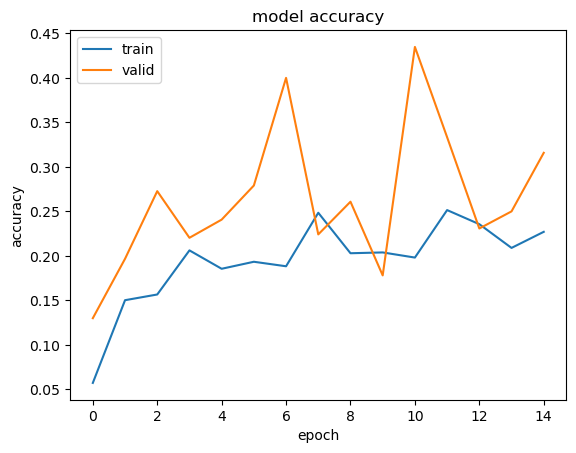

Test loss: 0.3338000774383545
Test accuracy: 0.26923078298568726


In [17]:
# Set calss weight to adjust the imbalance of data
weight_0 = 1 / np.bincount(y_train)[0]
weight_1 = 1 / np.bincount(y_train)[1]
class_weight = {0: weight_0, 1: weight_1}

batch_size = 16
epochs = 15

num_var = len(var_for_X)

# Create a Neural Net model and train/test it
model = Sequential([
    Dense(64, activation='relu', input_shape=(num_var,)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid'),
])

model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[keras.metrics.Precision()]
    )
results = model.fit(
    X_train, y_train, batch_size=batch_size,
    epochs=epochs, validation_split=0.2, class_weight=class_weight
    )

# Plot train/validate loss and scores
plt.plot(results.history["precision"])
plt.plot(results.history["val_precision"])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Test Score
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])